In [1]:
import numpy as np
import cv2
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
from skimage.feature import hog
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
%matplotlib inline

# print(sklearn.__version__)

car_folder = './vehicles/vehicles'
car_sub_folders = ['./GTI_Far/', './GTI_Left/', './GTI_MiddleClose/', './GTI_Right/', './KITTI_extracted/']

non_car_folder = './non-vehicles/non-vehicles'
non_car_sub_folders = ['./Extras/', './GTI/']

cars = []
notcars = []

for car_sub_folder in car_sub_folders:
    if not 'KITTI' in car_sub_folder:
        images = glob.glob(car_folder + car_sub_folder + 'image*.png')
    else:
        images = glob.glob(car_folder + car_sub_folder + '*.png')
    for image in images:
        cars.append(image)

print(len(cars))
        
for non_car_sub_folder in non_car_sub_folders:
    if not 'GTI' in non_car_sub_folder:
        images = glob.glob(non_car_folder + non_car_sub_folder + 'extra*.png')
    else:
        images = glob.glob(non_car_folder + non_car_sub_folder + 'image*.png')
    for image in images:
        notcars.append(image)
    
print(len(notcars))



8792
8968


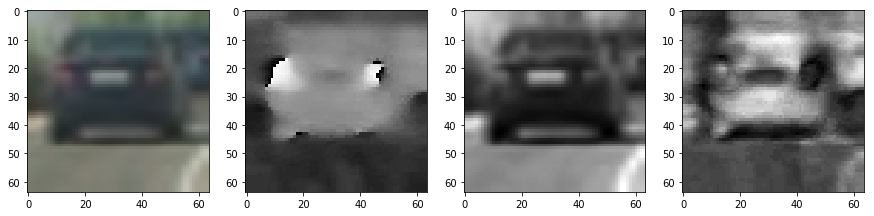

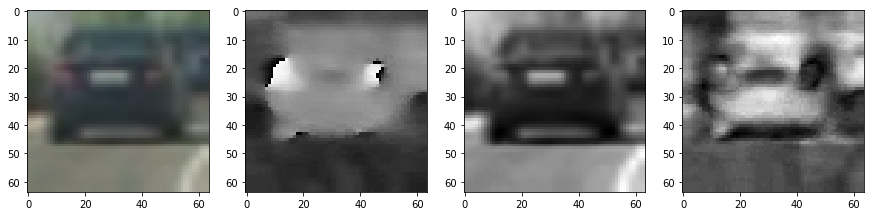

In [2]:
original = (np.array(mpimg.imread(cars[1]))*255).astype(np.uint8)
hls = cv2.cvtColor(original, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

plt.figure(figsize=(15,15))
plt.subplot(141)
plt.imshow(original)
plt.subplot(142)
plt.imshow(H, cmap='gray')
plt.subplot(143)
plt.imshow(L, cmap='gray')
plt.subplot(144)
plt.imshow(S, cmap='gray')

hsv = cv2.cvtColor(original, cv2.COLOR_RGB2HSV)
H = hsv[:,:,0]
S = hsv[:,:,1]
V = hsv[:,:,2]

plt.figure(figsize=(15,15))
plt.subplot(141)
plt.imshow(original)
plt.subplot(142)
plt.imshow(H, cmap='gray')
plt.subplot(143)
plt.imshow(V, cmap='gray')
plt.subplot(144)
plt.imshow(S, cmap='gray')

In [3]:
def convert_color(img, color='YCrCb'):
    if color == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if color == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if color == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if color == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=feature_vec)
        return features
    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = (np.array(mpimg.imread(file))*255).astype(np.uint8)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [4]:
def make_list(start, end, n=5):
        return np.linspace(start, end, n, dtype=np.int)

# def make_boxes(n=5):
#     

# make_list(250, 20)

395


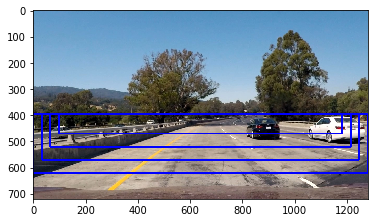

In [5]:
image = mpimg.imread('./test_images/test1.jpg')

n_window_layers = 4
# ((0, 400), (image.shape[1], 680)) largest layer
# ((250, 380), (image.shape[1]-250, 500)) smallest layer

max_box_size = 150
min_box_size = 50

box_size_list = make_list(max_box_size, min_box_size, n_window_layers)

x2_0 = image.shape[1]
y2_0 = 620
x1_0 = 0
y1_0 = y2_0-max_box_size*3//2

x1_end = 100
y1_end = y1_0+0
x2_end = x2_0 - x1_end
y2_end = y1_end + min_box_size*3//2

x1 = make_list(x1_0, x1_end, n_window_layers)
y1 = make_list(y1_0, y1_end, n_window_layers)
x2 = make_list(x2_0, x2_end, n_window_layers)
y2 = make_list(y2_0, y2_end, n_window_layers)

for i in range(n_window_layers):
    cv2.rectangle(image, (x1[i], y1[i]), (x2[i], y2[i]), (0,0,255), 6)

plt.imshow(image)

print(y1_0)
# print(y2-y1)
# print(box_size_list)

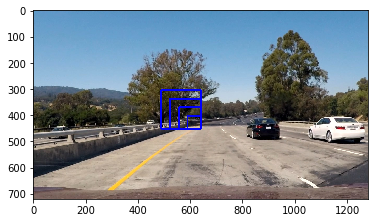

In [6]:
image = mpimg.imread('./test_images/test1.jpg')

# max_box_size = 300
# min_box_size = 70

box_size_list = make_list(max_box_size, min_box_size, n_window_layers)

for i in range(n_window_layers):
    test_box = ((int(image.shape[1]/2-box_size_list[i]), int(680/1.5-box_size_list[i])), (int(image.shape[1]/2), int(680/1.5)))
    cv2.rectangle(image, test_box[0], test_box[1], (0,0,255), 6)

plt.imshow(image)

In [7]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    img_shape = img.shape
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img_shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img_shape[0]
    # Compute the span of the region to be searched
    x_span = x_start_stop[1] - x_start_stop[0]
    y_span = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    n_pxl_per_step_x = np.int(xy_window[0] * (1 - xy_overlap[0]))
    n_pxl_per_step_y = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0] * xy_overlap[0])
    ny_buffer = np.int(xy_window[1] * xy_overlap[1])
    n_windows_x = np.int((x_span-nx_buffer) / n_pxl_per_step_x)
    n_windows_y = np.int((y_span-ny_buffer) / n_pxl_per_step_y)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
    for i in range(n_windows_x):
        for j in range(n_windows_y):
            # Calculate each window position
            start_x = x_start_stop[0] + i * n_pxl_per_step_x
            start_y = y_start_stop[0] + j * n_pxl_per_step_y
            end_x = start_x + xy_window[0]
            end_y = start_y + xy_window[1]
            # Append window position to list
            window_list.append(((start_x, start_y), (end_x, end_y)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [8]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [9]:
from sklearn.svm import LinearSVC

color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


C:\Users\jsa\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [10]:
from sklearn.model_selection import GridSearchCV

user_input = input('Train the classifier? (y/[n]) ')

if user_input == 'y':
    n_epochs = 1
    
    # Use a linear SVC (support vector classifier)
#     parameters = {'C':[0.1, 1, 10]}
    svc = LinearSVC(C=0.1)
#     svc = GridSearchCV(svr, parameters)
    t_train=time.time()
    for epoch in range(n_epochs):
        print('Epoch', epoch+1)
        t = time.time()
        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=rand_state)
        # Train the SVC
        svc.fit(X_train, y_train)
        t2 = time.time()
        print('Epoch', epoch+1, 'took', round(t2-t, 2), 'seconds.')
        
    t_train2=time.time()
    print(round(t_train2-t_train, 2), 'Seconds to train SVC...')
#     print(svc.best_params_)
    # save the classifier
    with open('vehicle_classifier.pkl', 'wb') as fid:
        pickle.dump(svc, fid)
else:
    # load it again
    with open('vehicle_classifier.pkl', 'rb') as fid:
        svc = pickle.load(fid)
    
# Check accuracy
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Train the classifier? (y/[n]) y
Epoch 1
Epoch 1 took 18.19 seconds.
18.19 Seconds to train SVC...
Test Accuracy of SVC =  0.9913


In [11]:
from scipy.ndimage.measurements import label

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color='HSV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5
    
    
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [18]:
def find_vehicles(image):
    n_window_layers = 5
    max_box_size = 150
    min_box_size = 50

    box_size_list = make_list(max_box_size, min_box_size, n_window_layers)

    x2_0 = image.shape[1]
    y2_0 = 620
    x1_0 = 0
    y1_0 = y2_0-max_box_size*3//2

    x1_end = 50
    y1_end = y1_0+0
    x2_end = x2_0 - x1_end
    y2_end = y1_end + min_box_size*3//2

    x1 = make_list(x1_0, x1_end, n_window_layers)
    y1 = make_list(y1_0, y1_end, n_window_layers)
    x2 = make_list(x2_0, x2_end, n_window_layers)
    y2 = make_list(y2_0, y2_end, n_window_layers)
    
    windows = []

    for i in range(n_window_layers):
        x_start_stop = [x1[i], x2[i]]
        y_start_stop = [y1[i], y2[i]]
        box_size = box_size_list[i]
        xy_window = (box_size, box_size)
        sub_windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                            xy_window=xy_window, xy_overlap=(0.6, 0.6))
        windows += sub_windows
        

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat, hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img, hot_windows, heatmap

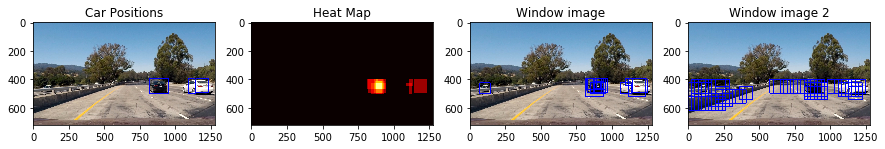

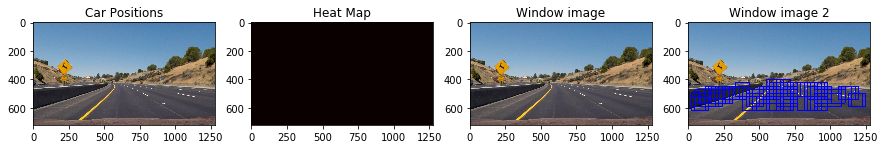

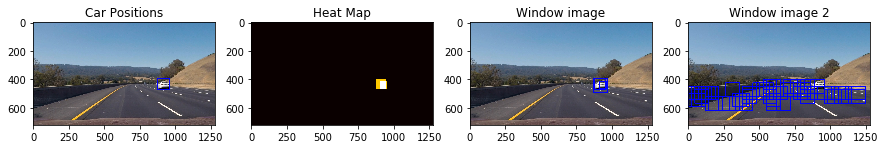

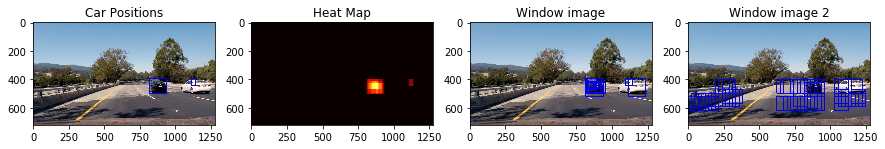

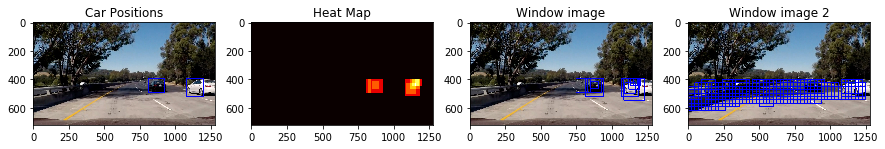

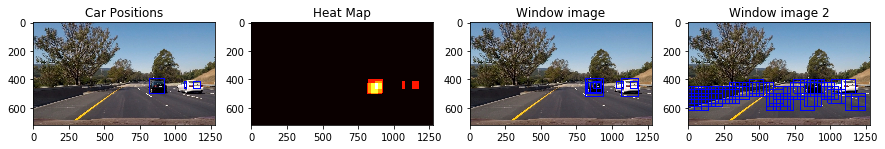

In [19]:
test_images = glob.glob('./test_images/test*.jpg')
for file in test_images:
    image = mpimg.imread(file)
    draw_image = np.copy(image)
    
    draw_img, hot_windows, heatmap = find_vehicles(image)
   
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    
    out_img = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
   
    fig = plt.figure(figsize=(15,15))
    plt.subplot(141)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(142)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.subplot(143)
    plt.imshow(window_img)
    plt.title('Window image')
    plt.subplot(144)
    plt.imshow(out_img)
    plt.title('Window image 2')
#     fig.tight_layout()
    

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_images(image):
    draw_img, hot_windows, heatmap = find_vehicles(image)
    return draw_img

In [21]:
test_video_output = './output_images/output_test_video.mp4'

clip2 = VideoFileClip("./test_video.mp4")
test_clip = clip2.fl_image(process_images) #NOTE: this function expects color images!!
%time test_clip.write_videofile(test_video_output, audio=False)

[MoviePy] >>>> Building video ./output_images/output_test_video.mp4
[MoviePy] Writing video ./output_images/output_test_video.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [01:10<00:02,  2.06s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/output_test_video.mp4 

Wall time: 1min 12s


In [ ]:
project_video_output = './output_images/output_project_video.mp4'

clip1 = VideoFileClip("./project_video.mp4")
project_clip = clip1.fl_image(process_images) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_video_output, audio=False)